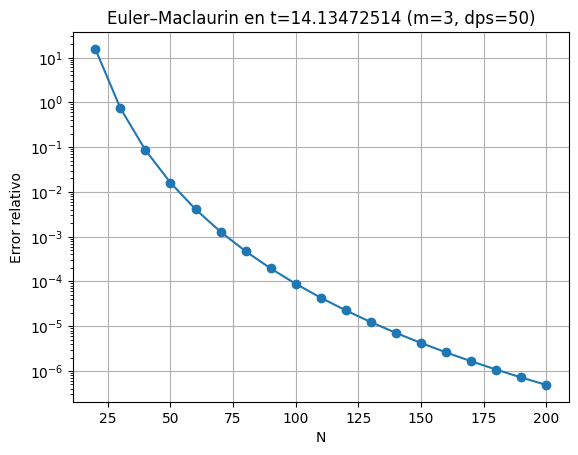

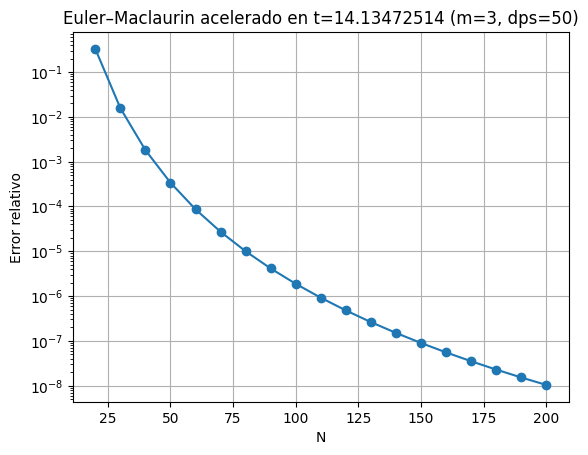

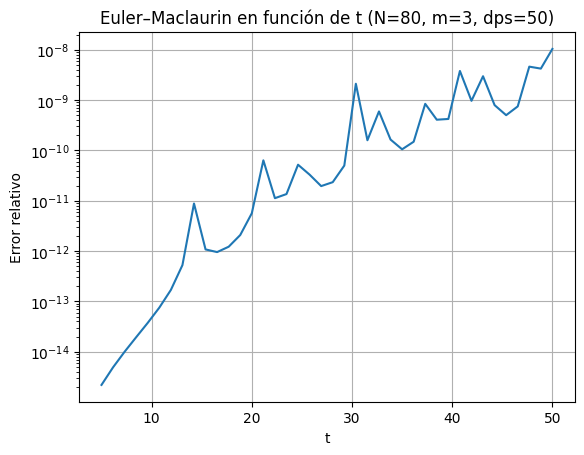

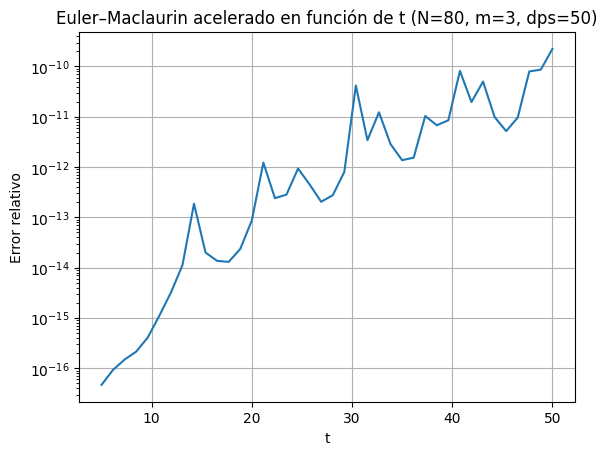

In [ ]:


def zeta_reference(t, dps_ref=100):
    """
    Valor de referencia 'muy preciso' de ζ(1/2 + i t) usando mpmath.zeta
    con una precisión alta (dps_ref).
    """
    with mp.workdps(dps_ref):
        s = mp.mpf('0.5') + 1j * mp.mpf(t)
        return mp.zeta(s)




def plot_error_vs_N(t=14.13472514,
                    N_min=10, N_max=200, step=10,
                    m=3, dps=50,
                    use_relative=False,
                    method="em",
                    p_acc=None,
                    dps_ref=100):

    set_precision(dps)

    # Valor de referencia con precisión alta
    z_ref = zeta_reference(t, dps_ref=dps_ref)

    N_values = list(range(N_min, N_max + 1, step))
    errors = []

    for N in N_values:
        if method == "em":
            z_approx = zeta_em(t, N, m)
        elif method == "em_acc":
            z_approx = zeta_em_acc(t, N, m, p=p_acc)
        else:
            raise ValueError("method debe ser 'em' o 'em_acc'.")

        err_abs = abs(z_approx - z_ref)
        if use_relative:
            err = err_abs / abs(z_ref) if z_ref != 0 else mp.nan
        else:
            err = err_abs

        errors.append(float(err))

    plt.figure()
    plt.semilogy(N_values, errors, marker="o")
    plt.xlabel("N")
    ylabel = "Error relativo" if use_relative else "Error absoluto"
    plt.ylabel(ylabel)

    if method == "em":
        metodo_str = "Euler–Maclaurin"
    else:
        metodo_str = "Euler–Maclaurin acelerado"

    plt.title(f"{metodo_str} en t={t:.8f} (m={m}, dps={dps})")
    plt.grid(True)
    plt.show()



# Gráfico: error vs t para N y m fijos


def plot_error_vs_t(t_min=5, t_max=50, num_points=50,
                    N=80, m=3, dps=50,
                    use_relative=False,
                    method="em",
                    p_acc=None,
                    dps_ref=100):

    set_precision(dps)

    t_values = np.linspace(t_min, t_max, num_points)
    errors = []

    for t in t_values:
        z_ref = zeta_reference(t, dps_ref=dps_ref)

        if method == "em":
            z_approx = zeta_em(t, N, m)
        elif method == "em_acc":
            z_approx = zeta_em_acc(t, N, m, p=p_acc)
        else:
            raise ValueError("method debe ser 'em' o 'em_acc'.")

        err_abs = abs(z_approx - z_ref)
        if use_relative:
            err = err_abs / abs(z_ref) if z_ref != 0 else mp.nan
        else:
            err = err_abs

        errors.append(float(err))

    plt.figure()
    plt.semilogy(t_values, errors)
    plt.xlabel("t")
    ylabel = "Error relativo" if use_relative else "Error absoluto"
    plt.ylabel(ylabel)

    if method == "em":
        metodo_str = "Euler–Maclaurin"
    else:
        metodo_str = "Euler–Maclaurin acelerado"

    plt.title(f"{metodo_str} en función de t (N={N}, m={m}, dps={dps})")
    plt.grid(True)
    plt.show()




# Comparar EM vs EM-acc en el primer cero
t_cero1 = 14.13472514

plot_error_vs_N(
    t=t_cero1,
    N_min=20,
    N_max=200,
    step=10,
    m=3,
    dps=50,
    use_relative=True,
    method="em"      # EM normal
)

plot_error_vs_N(
    t=t_cero1,
    N_min=20,
    N_max=200,
    step=10,
    m=3,
    dps=50,
    use_relative=True,
    method="em_acc", # EM acelerado
    p_acc=None
)


# Error vs t para un N fijo
plot_error_vs_t(
    t_min=5,
    t_max=50,
    num_points=40,
    N=80,
    m=3,
    dps=50,
    use_relative=True,
    method="em"
)

plot_error_vs_t(
    t_min=5,
    t_max=50,
    num_points=40,
    N=80,
    m=3,
    dps=50,
    use_relative=True,
    method="em_acc",
    p_acc=None
)



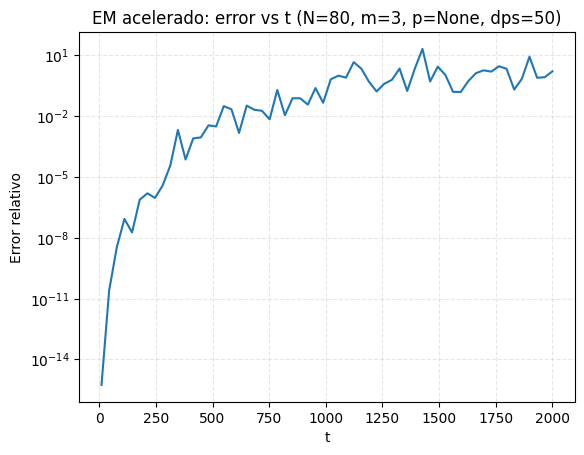

In [ ]:


def plot_error_vs_t_em_acc(
    N=80,
    m=3,
    p=None,
    dps=50,
    t_min=10.0,
    t_max=2000.0,
    num_points=60,
    use_relative=True,
    dps_ref=100
):


    set_precision(dps)

    t_values = np.linspace(t_min, t_max, num_points)

    errors = []
    for t in t_values:
        z_ref = zeta_reference(t, dps_ref=dps_ref)
        z_acc = zeta_em_acc(t, N, m=m, p=p)

        abs_err = mp.fabs(z_acc - z_ref)
        if use_relative and z_ref != 0:
            err = abs_err / mp.fabs(z_ref)
        else:
            err = abs_err
        errors.append(float(err))

    t_plot = [float(t) for t in t_values]

    plt.figure()
    plt.semilogy(t_plot, errors)
    plt.xlabel("t")
    plt.ylabel("Error relativo" if use_relative else "Error absoluto")
    plt.title(f"EM acelerado: error vs t (N={N}, m={m}, p={p}, dps={dps})")
    plt.grid(True, which="both", linestyle="--", alpha=0.3)
    plt.show()

plot_error_vs_t_em_acc()


In [ ]:
from mpmath import mp
import numpy as np
import matplotlib.pyplot as plt
import time



def set_precision(dps=50):
    mp.dps = dps




def _main_sum_zeta(s, N):
    N = int(N)
    total = mp.mpc(0)
    for n in range(1, N):
        total += n ** (-s)
    return total

def _tail_integral(s, N):
    N = mp.mpf(N)
    return N ** (1 - s) / (s - 1)

def _tail_half_term(s, N):
    N = mp.mpf(N)
    return mp.mpf('0.5') * N ** (-s)

def _tail_corrections(s, N, m):
    N = mp.mpf(N)
    corrections = mp.mpc(0)
    for k in range(1, m + 1):
        B_2k = mp.bernoulli(2 * k)   # B_{2k}
        fact = mp.factorial(2 * k)   # (2k)!
        rising = mp.rf(s, 2 * k - 1) # (s)_{2k-1}
        term = (B_2k / fact) * rising * N ** (-s - 2 * k + 1)
        corrections += term
    return corrections

def _tail_em(s, N, m):
    return _tail_integral(s, N) + _tail_half_term(s, N) + _tail_corrections(s, N, m)



def zeta_em_s(s, N, m=2):

    s = mp.mpc(s)
    main_sum = _main_sum_zeta(s, N)
    tail = _tail_em(s, N, m)
    return main_sum + tail

def zeta_em(t, N, m=2):

    t = mp.mpf(t)
    s = mp.mpf('0.5') + 1j * t
    return zeta_em_s(s, N, m)



# Método Euler–Maclaurin "acelerado"


def zeta_em_acc(t, N, m=2, p=None):

    if p is None:
        p = 2 * m

    N = int(N)
    if N <= 0:
        raise ValueError("N debe ser un entero positivo.")

    A1 = zeta_em(t, N, m)
    A2 = zeta_em(t, 2 * N, m)

    factor = 2 ** p

    return (factor * A2 - A1) / (factor - 1)




def test_em_acc_values(N=40, m=3, dps=50, p=None):
    set_precision(dps)

    t_values = [
        10,
        20,
        30,
        14.13472514,   # Primer cero
        21.02203964,   # Segundo cero
        25.01085758,   # Tercer cero
        100.0,
        200.0,
        500.0,
        1000.0,
        2000.0,
        3000.0
    ]

    print(f"\n--- Test EM acelerado (Richardson) con N={N}, m={m}, p={p}, dps={dps} ---\n")

    header = (
        f"{'t':>12} | {'zeta_mpmath':>30} | {'zeta_EM_acc':>30} | "
        f"{'err_abs':>12} | {'err_rel':>12} | {'time_s':>10}"
    )
    print(header)
    print("-" * len(header))

    for t in t_values:
        s = 0.5 + 1j * t

        # Valor de referencia
        z_ref = mp.zeta(s)

        # Tiempo del método EM acelerado
        t0 = time.perf_counter()
        z_em_acc_val = zeta_em_acc(t, N, m=m, p=p)
        t1 = time.perf_counter()
        elapsed = t1 - t0

        # Errores (comparando con zeta_em_acc!)
        err_abs = abs(z_ref - z_em_acc_val)
        err_rel = err_abs / abs(z_ref) if z_ref != 0 else mp.nan

        # Pasar todo a float para formatear sin problemas
        t_print     = float(t)
        z_ref_real  = float(mp.re(z_ref))
        z_acc_real  = float(mp.re(z_em_acc_val))
        err_abs_f   = float(err_abs)
        err_rel_f   = float(err_rel) if not mp.isnan(err_rel) else float('nan')
        elapsed_f   = float(elapsed)

        print(
            f"{t_print:12.8f} | "
            f"{z_ref_real:30.12f} | "
            f"{z_acc_real:30.12f} | "
            f"{err_abs_f:12.2e} | "
            f"{err_rel_f:12.2e} | "
            f"{elapsed_f:10.4f}"
        )

    print("\nTest completado.\n")




# Ejecutamos test por defecto:
test_em_acc_values(N=100, m=3, dps=50, p=None)  # o p=2*m si quieres fijarlo




--- Test EM acelerado (Richardson) con N=100, m=3, p=None, dps=50 ---

           t |                    zeta_mpmath |                    zeta_EM_acc |      err_abs |      err_rel |     time_s
-------------------------------------------------------------------------------------------------------------------------
 10.00000000 |                 1.544895220297 |                 1.544895220297 |     1.62e-16 |     1.05e-16 |     0.0179
 20.00000000 |                 0.429913860438 |                 0.429913860438 |     1.86e-14 |     1.62e-14 |     0.0179
 30.00000000 |                -0.120642287590 |                -0.120642287590 |     3.60e-13 |     6.04e-13 |     0.0171
 14.13472514 |                 0.000000000216 |                 0.000000000216 |     2.58e-15 |     1.87e-06 |     0.0169
 21.02203964 |                 0.000000000306 |                 0.000000000306 |     3.22e-14 |     2.30e-05 |     0.0164
 25.01085758 |                 0.000000000066 |                 0.00000000